![movie photo](../images/premium_photo-1661675440353-6a6019c95bc7.jpeg)

# Analysis of Movie Data for Business Insights

## Overview


This report analyzes data from Box Office Mojo and IMDB to identify key factors that influence box office success. The primary goal is to help a new movie studio make data-driven decisions to optimize revenue by examining genre performance, the impact of director loyalty, and the power of franchises. The findings from this analysis will provide strategic insights for movie selection, talent retention, and franchise development to maximize box office gross.

## Business Problem

A new movie studio is looking to produce films that will generate significant box office revenue. To guide their business decisions, the studio needs insights into how various factors like genre, director-studio loyalty, and franchise involvement affect total gross revenue. The analysis addresses three main questions:

1. Which genres should the studio focus on to meet or exceed a target annual revenue of $2,128,500,000?
2. How does director loyalty or studio collaboration affect box office success?
3. What impact does franchise power have on revenue?

By answering these questions, the studio will have the tools to focus on the right types of films and build lasting director-studio relationships for successful franchises.

## Data Understanding

The analysis combines data from two main sources:

- Box Office Mojo (BOM): This dataset contains information on 3,387 movies released between 2010 and 2018, including domestic and foreign box office gross.

- IMDB Database: This database includes detailed information on 146,144 movies, such as cast, crew, genres, and ratings. The key variables used in this analysis are domestic gross, foreign gross, studio, director, and whether the movie belongs to a franchise.

These datasets were merged and cleaned to create a comprehensive view of movie performance and underlying factors.

## 1.1 Load the Datasets

In [12]:
# Imports
import sqlite3
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Box office Data

In [13]:
box_office_data = pd.read_csv('../data/bom.movie_gross.csv.gz')

In [14]:
box_office_data.head()

title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010

In [15]:
box_office_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [16]:
box_office_data["year"].value_counts()

year
2015    450
2016    436
2012    400
2011    399
2014    395
2013    350
2010    328
2017    321
2018    308
Name: count, dtype: int64

In [17]:
box_office_data.describe()

domestic_gross         year
count    3.359000e+03  3387.000000
mean     2.874585e+07  2013.958075
std      6.698250e+07     2.478141
min      1.000000e+02  2010.000000
25%      1.200000e+05  2012.000000
50%      1.400000e+06  2014.000000
75%      2.790000e+07  2016.000000
max      9.367000e+08  2018.000000

### IMDb Data

In [18]:
# Connect to the database
conn = sqlite3.connect('../data/im.db')

In [19]:
#View all data from sqlite_master such as table names
query = "SELECT * FROM sqlite_master"

In [20]:
# Load the data into a pandas DataFrame
imdb_data = pd.read_sql(query, conn)
imdb_data

Empty DataFrame
Columns: [type, name, tbl_name, rootpage, sql]
Index: []

## 1.2 Understand the structure:

### Box Office Data Key Features

- title (movie title)
- studio (movie production studio)
- domestic_gross (revenue from domestic box office)
- foreign_gross (revenue from foreign box office)
- year (release year)

Key Data Insights:

- Some missing values in studio and domestic_gross.
- Significant missing values in foreign_gross.
- Data types are generally correct except for foreign_gross, which is stored as object but should likely be float64 to handle numeric operations.

### IMDB Features
- movie_basics: Contains key information about movies like movie_id, title, genre, runtime_minutes, start_year, etc.
- directors: Links directors to movies via movie_id.
- known_for: Associates people (person_id) with movies.
- movie_ratings: Contains information about movie ratings (average_rating, num_votes).
- persons: Holds person-specific details such as name, birth_year, death_year, etc.
- principals: Contains cast and crew information for each movie.
- writers: Links writers to movies via movie_id.

### Data Distribution of Key Categorical Variables (Box Office Data)

In [21]:
# Distribution of studios
print(box_office_data['studio'].value_counts())

# Distribution of years
print(box_office_data['year'].value_counts())

studio
IFC           166
Uni.          147
WB            140
Fox           136
Magn.         136
             ... 
E1              1
PI              1
ELS             1
PalT            1
Synergetic      1
Name: count, Length: 257, dtype: int64
year
2015    450
2016    436
2012    400
2011    399
2014    395
2013    350
2010    328
2017    321
2018    308
Name: count, dtype: int64


This would show which studios and years are most represented in the dataset, which can help analyze trends over time or by studio.

### Distribution of Key Categorical Variables (IMDB Database):

In [22]:
# Distribution of genres in movie_basics
query1 = "SELECT genres FROM movie_basics"
movie_genres = pd.read_sql(query1, conn)
print(movie_genres['genres'].value_counts())

# Distribution of directors
query2 = "SELECT primary_name FROM persons JOIN directors USING(person_id)"
director_names = pd.read_sql(query2, conn)
print(director_names['primary_name'].value_counts())

DatabaseError: Execution failed on sql 'SELECT genres FROM movie_basics': no such table: movie_basics

This gives an idea of which genres are most common and which directors have worked on the most films.

## 1.3 Identify Relationships Between Datasets
Merging Box Office Mojo with IMDB Database:
 - Possible keys: Merge the Box Office Mojo dataset and the IMDB data using the title field from Box Office Mojo and the title field in the movie_basics table. Another option could be to use the movie_id from the IMDB database if it exists in both datasets.

Merging Tables within the IMDB Database:

- The tables within the IMDB database can be merged using movie_id to combine relevant information

  - movie_basics with movie_ratings to get both the movie details and their ratings.
  - movie_basics with directors, writers, or principals to understand crew members associated with each movie.

## Data Preparation & Cleaning

## 2.1 Handle Incorrect Data Types
- Convert columns to their correct data types. 
- Convert the foreign_gross column to numeric values since it's currently stored as an object.

In [82]:
# Convert 'foreign_gross' to numeric, coerce errors
box_office_data['foreign_gross'] = pd.to_numeric(box_office_data['foreign_gross'], errors='coerce')
(box_office_data['foreign_gross'])

0       652000000.0
1       691300000.0
2       664300000.0
3       535700000.0
4       513900000.0
           ...     
3382            NaN
3383            NaN
3384            NaN
3385            NaN
3386            NaN
Name: foreign_gross, Length: 3387, dtype: float64

## 2.2 Handle Missing Values
As mentioned earlier, there are missing values in the studio, domestic_gross and in foreign_gross columns in the box office data.

- Use isnull() and sum() to identify columns with missing data.

Depending on the context:
- Drop rows or columns with a large amount of missing data using dropna().
- Impute missing values with appropriate statistics (mean, median, mode) using fillna().

1. studio (5 missing values):
- Fill in the missing values with "Unknown" rather than dropping them. These movies still have important data like gross earnings, which is crucial for analysis.
  - The studio is not the primary focus of our analysis, and removing these rows could unnecessarily reduce the size of our dataset.

In [83]:
box_office_data['studio'].fillna('Unknown', inplace=True)
box_office_data['studio']

0               BV
1               BV
2               WB
3               WB
4             P/DW
           ...    
3382         Magn.
3383            FM
3384          Sony
3385    Synergetic
3386         Grav.
Name: studio, Length: 3387, dtype: object

2. domestic_gross (28 missing values):
- Drop rows where domestic_gross is missing.
  - Missing domestic gross values make it impossible to assess a movie’s financial performance, which is essential for our analysis. Imputing a value here (e.g., with a mean or median) could distort our analysis.

In [84]:
box_office_data = box_office_data.dropna(subset=['domestic_gross'])
box_office_data['domestic_gross']

0       415000000.0
1       334200000.0
2       296000000.0
3       292600000.0
4       238700000.0
           ...     
3382         6200.0
3383         4800.0
3384         2500.0
3385         2400.0
3386         1700.0
Name: domestic_gross, Length: 3359, dtype: float64

3. foreign_gross (1350 missing values):
- Fill in missing foreign_gross values with 0.
  - While a missing foreign gross could imply that the movie was not released internationally, setting the value to 0 allows us to continue analyzing its total performance, especially if it performed well domestically.

In [85]:
# check to see if there are any null values in foreign_gross
box_office_data['foreign_gross'].isna().sum()

1355

In [86]:
# replace these null values with 0
box_office_data["foreign_gross"].fillna(0, inplace=True)

box_office_data['foreign_gross'].isna().sum()

0

## 2.3 Splitting and Normalizing the Genres Columns
- Problem: Movies might be listed with multiple genres (e.g., Action, Comedy), so we need to normalize the genre data for easier analysis.
- Solution: Split the genres into separate rows so that each movie has one genre per row.

In [87]:
# putting all movie_basics info inside 1 df
movie_basics_df = pd.read_sql(
"""
SELECT *
FROM movie_basics
"""
, conn)
movie_basics_df.head()

movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80.0  Comedy,Drama,Fantasy

In [88]:
# Split the 'genres' column by commas
movie_basics_df['individual_genre'] = movie_basics_df['genres'].str.split(',')

# Explode the list of genres into individual rows
movie_basics_df = movie_basics_df.explode('individual_genre')
movie_basics_df

movie_id                                primary_title  \
0       tt0063540                                    Sunghursh   
0       tt0063540                                    Sunghursh   
0       tt0063540                                    Sunghursh   
1       tt0066787              One Day Before the Rainy Season   
1       tt0066787              One Day Before the Rainy Season   
...           ...                                          ...   
146139  tt9916538                          Kuambil Lagi Hatiku   
146140  tt9916622  Rodolpho Teóphilo - O Legado de um Pioneiro   
146141  tt9916706                              Dankyavar Danka   
146142  tt9916730                                       6 Gunn   
146143  tt9916754               Chico Albuquerque - Revelações   

                                     original_title  start_year  \
0                                         Sunghursh        2013   
0                                         Sunghursh        2013   
0                                         Sunghursh        2013   
1                                   Ashad Ka Ek Din        2019   
1                                   Ashad Ka Ek Din        2019   
...                                             ...         ...   
146139                          Kuambil Lagi Hatiku        2019   
146140  Rodolpho Teóphilo - O Legado de um Pioneiro        2015   
146141                              Dankyavar Danka        2013   
146142                                       6 Gunn        2017   
146143               Chico Albuquerque - Revelações        2013   

        runtime_minutes              genres individual_genre  
0                 175.0  Action,Crime,Drama           Action  
0                 175.0  Action,Crime,Drama            Crime  
0                 175.0  Action,Crime,Drama            Drama  
1                 114.0     Biography,Drama        Biography  
1                 114.0     Biography,Drama            Drama  
...                 ...                 ...              ...  
146139            123.0               Drama            Drama  
146140              NaN         Documentary      Documentary  
146141              NaN              Comedy           Comedy  
146142            116.0                None             None  
146143              NaN         Documentary      Documentary  

[234958 rows x 7 columns]

In [89]:
# check to see if there are null values in individual_genre
movie_basics_df["individual_genre"].isna().sum()

5408

In [90]:
# replace null values in individual_genre with "Unknown"
movie_basics_df["individual_genre"].fillna("Unknown", inplace=True)

movie_basics_df["individual_genre"].isna().sum()

0

This step ensures that genre analysis will be more accurate, as movies with multiple genres will be counted individually for each genre.

## 2.4 Splitting and Normalizing the Genres Columns
- Problem: Movies might be listed with multiple genres (e.g., Action, Comedy), so we need to normalize the genre data for easier analysis.
- Solution: Split the genres into separate rows so that each movie has one genre per row.

In [91]:
# putting all movie_basics info inside 1 df
movie_basics_df = pd.read_sql(
"""
SELECT *
FROM movie_basics
"""
, conn)
movie_basics_df.head()

movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80.0  Comedy,Drama,Fantasy

In [92]:
# Split the 'genres' column by commas
movie_basics_df['individual_genre'] = movie_basics_df['genres'].str.split(',')

# Explode the list of genres into individual rows
movie_basics_df = movie_basics_df.explode('individual_genre')
movie_basics_df

movie_id                                primary_title  \
0       tt0063540                                    Sunghursh   
0       tt0063540                                    Sunghursh   
0       tt0063540                                    Sunghursh   
1       tt0066787              One Day Before the Rainy Season   
1       tt0066787              One Day Before the Rainy Season   
...           ...                                          ...   
146139  tt9916538                          Kuambil Lagi Hatiku   
146140  tt9916622  Rodolpho Teóphilo - O Legado de um Pioneiro   
146141  tt9916706                              Dankyavar Danka   
146142  tt9916730                                       6 Gunn   
146143  tt9916754               Chico Albuquerque - Revelações   

                                     original_title  start_year  \
0                                         Sunghursh        2013   
0                                         Sunghursh        2013   
0                                         Sunghursh        2013   
1                                   Ashad Ka Ek Din        2019   
1                                   Ashad Ka Ek Din        2019   
...                                             ...         ...   
146139                          Kuambil Lagi Hatiku        2019   
146140  Rodolpho Teóphilo - O Legado de um Pioneiro        2015   
146141                              Dankyavar Danka        2013   
146142                                       6 Gunn        2017   
146143               Chico Albuquerque - Revelações        2013   

        runtime_minutes              genres individual_genre  
0                 175.0  Action,Crime,Drama           Action  
0                 175.0  Action,Crime,Drama            Crime  
0                 175.0  Action,Crime,Drama            Drama  
1                 114.0     Biography,Drama        Biography  
1                 114.0     Biography,Drama            Drama  
...                 ...                 ...              ...  
146139            123.0               Drama            Drama  
146140              NaN         Documentary      Documentary  
146141              NaN              Comedy           Comedy  
146142            116.0                None             None  
146143              NaN         Documentary      Documentary  

[234958 rows x 7 columns]

In [93]:
# check to see if there are null values in individual_genre
movie_basics_df["individual_genre"].isna().sum()

5408

In [94]:
# replace null values in individual_genre with "Unknown"
movie_basics_df["individual_genre"].fillna("Unknown", inplace=True)

movie_basics_df["individual_genre"].isna().sum()

0

This step ensures that genre analysis will be more accurate, as movies with multiple genres will be counted individually for each genre.

## 2.5 Handling Director Information
- Instead of relying on person_id, we can join the directors table with the persons table to get director names for easier interpretation.
- This will be helpful when identifying relationships between directors and movie success.

In [95]:
# get director name of each movie
query3 = """
SELECT DISTINCT movie_id, person_id AS director_id, primary_name AS director_name
FROM persons JOIN directors USING(person_id)
"""
movie_director_details = pd.read_sql(query3, conn)
movie_director_details

movie_id director_id   director_name
0       tt1592569   nm0062879  Ruel S. Bayani
1       tt2057445   nm0062879  Ruel S. Bayani
2       tt2590280   nm0062879  Ruel S. Bayani
3       tt8421806   nm0062879  Ruel S. Bayani
4       tt3501180   nm0064023   Bryan Beasley
...           ...         ...             ...
163528  tt8697720   nm9971456       Zheng Wei
163529  tt8715016   nm9980896  Rama Narayanan
163530  tt8919136   nm9980896  Rama Narayanan
163531  tt8717234   nm9981679     Samir Eshra
163532  tt8743182   nm9993380  Pegasus Envoyé

[163533 rows x 3 columns]

## Data Transformation

## 3.1 Filter for relevant features:
From Box Office Mojo Data:
- title: This is necessary to match movies with other datasets.
- studio: analyze which studios are producing successful movies.
- domestic_gross: This is the revenue generated domestically, which is a key measure of box office performance.
- foreign_gross: Revenue generated in foreign markets, another important aspect of box office success.
- year: Useful to analyze trends over time.

In [96]:
# Select relevant columns from Box Office Mojo data
box_office_filtered = box_office_data[['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']]
box_office_filtered

title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

      foreign_gross  year  
0       652000000.0  2010  
1       691300000.0  2010  
2       664300000.0  2010  
3       535700000.0  2010  
4       513900000.0  2010  
...             ...   ...  
3382            0.0  2018  
3383            0.0  2018  
3384            0.0  2018  
3385            0.0  2018  
3386            0.0  2018  

[3359 rows x 5 columns]

From IMDB SQL Database:
- movie_basics (from movie_basics table):
  - genres: Key feature to analyze which genres are most successful.
  - runtime_minutes: This could be useful for analyzing whether longer or shorter movies perform better.
  - title: To match with the Box Office data.

- movie_ratings (from movie_ratings table):
  - average_rating: This is the IMDB rating, useful to analyze the relationship between ratings and success.
  - num_votes: Number of votes can help measure how popular or widely seen the movie is.
- directors (optional for analyzing the influence of directors):
  - person_id: This can be linked to the persons table to get the director's name and further explore the influence of certain directors.

In [97]:
# Filter data from the cleaned df -- movie_basics_df 

movie_basics_filtered = movie_basics_df[["movie_id", "primary_title", "genres", "individual_genre", "runtime_minutes"]]
movie_basics_filtered

movie_id                                primary_title  \
0       tt0063540                                    Sunghursh   
0       tt0063540                                    Sunghursh   
0       tt0063540                                    Sunghursh   
1       tt0066787              One Day Before the Rainy Season   
1       tt0066787              One Day Before the Rainy Season   
...           ...                                          ...   
146139  tt9916538                          Kuambil Lagi Hatiku   
146140  tt9916622  Rodolpho Teóphilo - O Legado de um Pioneiro   
146141  tt9916706                              Dankyavar Danka   
146142  tt9916730                                       6 Gunn   
146143  tt9916754               Chico Albuquerque - Revelações   

                    genres individual_genre  runtime_minutes  
0       Action,Crime,Drama           Action            175.0  
0       Action,Crime,Drama            Crime            175.0  
0       Action,Crime,Drama            Drama            175.0  
1          Biography,Drama        Biography            114.0  
1          Biography,Drama            Drama            114.0  
...                    ...              ...              ...  
146139               Drama            Drama            123.0  
146140         Documentary      Documentary              NaN  
146141              Comedy           Comedy              NaN  
146142                None          Unknown            116.0  
146143         Documentary      Documentary              NaN  

[234958 rows x 5 columns]

In [98]:
query_movie_ratings = """
SELECT movie_id, averagerating, numvotes
FROM movie_ratings
"""
movie_ratings_filtered = pd.read_sql(query_movie_ratings, conn)

movie_ratings_filtered

movie_id  averagerating  numvotes
0      tt10356526            8.3        31
1      tt10384606            8.9       559
2       tt1042974            6.4        20
3       tt1043726            4.2     50352
4       tt1060240            6.5        21
...           ...            ...       ...
73851   tt9805820            8.1        25
73852   tt9844256            7.5        24
73853   tt9851050            4.7        14
73854   tt9886934            7.0         5
73855   tt9894098            6.3       128

[73856 rows x 3 columns]

Join the Box Office and IMDB Data:

Join on title (or movie_id if possible) to merge the Box Office data with the relevant IMDB data.

In [99]:
movie_basics_filtered.head()

movie_id                    primary_title              genres  \
0  tt0063540                        Sunghursh  Action,Crime,Drama   
0  tt0063540                        Sunghursh  Action,Crime,Drama   
0  tt0063540                        Sunghursh  Action,Crime,Drama   
1  tt0066787  One Day Before the Rainy Season     Biography,Drama   
1  tt0066787  One Day Before the Rainy Season     Biography,Drama   

  individual_genre  runtime_minutes  
0           Action            175.0  
0            Crime            175.0  
0            Drama            175.0  
1        Biography            114.0  
1            Drama            114.0

In [100]:
box_office_filtered.head()

title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

   foreign_gross  year  
0    652000000.0  2010  
1    691300000.0  2010  
2    664300000.0  2010  
3    535700000.0  2010  
4    513900000.0  2010

In [101]:
# Merge Box Office and IMDB data
merged_data = movie_basics_filtered
merged_data = merged_data.merge(box_office_filtered, left_on="primary_title", right_on="title", suffixes=("_movie", "_bo"))

# Adding rating data to merged_data df
merged_data = merged_data.merge(movie_ratings_filtered, on="movie_id", suffixes=("_movie", "_rating"))

# adding director details to merged_data
merged_data = merged_data.merge(movie_director_details, on="movie_id", suffixes=("_movie", "_dir"))

# there are 2999 unique movies in merged_data
print(len(merged_data["movie_id"].unique()))

merged_data

2999


movie_id              primary_title                   genres  \
0     tt0315642                      Wazir       Action,Crime,Drama   
1     tt0315642                      Wazir       Action,Crime,Drama   
2     tt0315642                      Wazir       Action,Crime,Drama   
3     tt0337692                On the Road  Adventure,Drama,Romance   
4     tt0337692                On the Road  Adventure,Drama,Romance   
...         ...                        ...                      ...   
7764  tt8427036            Helicopter Eela                    Drama   
7765  tt9078374                Last Letter            Drama,Romance   
7766  tt9078374                Last Letter            Drama,Romance   
7767  tt9151704  Burn the Stage: The Movie        Documentary,Music   
7768  tt9151704  Burn the Stage: The Movie        Documentary,Music   

     individual_genre  runtime_minutes                      title     studio  \
0              Action            103.0                      Wazir    Relbig.   
1               Crime            103.0                      Wazir    Relbig.   
2               Drama            103.0                      Wazir    Relbig.   
3           Adventure            124.0                On the Road        IFC   
4               Drama            124.0                On the Road        IFC   
...               ...              ...                        ...        ...   
7764            Drama            135.0            Helicopter Eela       Eros   
7765            Drama            114.0                Last Letter         CL   
7766          Romance            114.0                Last Letter         CL   
7767      Documentary             84.0  Burn the Stage: The Movie  Trafalgar   
7768            Music             84.0  Burn the Stage: The Movie  Trafalgar   

      domestic_gross  foreign_gross  year  averagerating  numvotes  \
0          1100000.0            0.0  2016            7.1     15378   
1          1100000.0            0.0  2016            7.1     15378   
2          1100000.0            0.0  2016            7.1     15378   
3           744000.0      8000000.0  2012            6.1     37886   
4           744000.0      8000000.0  2012            6.1     37886   
...              ...            ...   ...            ...       ...   
7764         72000.0            0.0  2018            5.4       673   
7765        181000.0            0.0  2018            6.4       322   
7766        181000.0            0.0  2018            6.4       322   
7767       4200000.0     16100000.0  2018            8.8      2067   
7768       4200000.0     16100000.0  2018            8.8      2067   

     director_id   director_name  
0      nm2349060   Bejoy Nambiar  
1      nm2349060   Bejoy Nambiar  
2      nm2349060   Bejoy Nambiar  
3      nm0758574   Walter Salles  
4      nm0758574   Walter Salles  
...          ...             ...  
7764   nm1224879  Pradeep Sarkar  
7765   nm0412517     Shunji Iwai  
7766   nm0412517     Shunji Iwai  
7767  nm10201503    Jun-Soo Park  
7768  nm10201503    Jun-Soo Park  

[7769 rows x 14 columns]

## 3.2 Create New Features:
Return on Investment (ROI): A critical metric to see how profitable a movie is.

In [102]:
# creating new column total_gross for domestic + foreign revenue
merged_data["total_gross"] = merged_data["domestic_gross"] + merged_data["foreign_gross"]
merged_data

movie_id              primary_title                   genres  \
0     tt0315642                      Wazir       Action,Crime,Drama   
1     tt0315642                      Wazir       Action,Crime,Drama   
2     tt0315642                      Wazir       Action,Crime,Drama   
3     tt0337692                On the Road  Adventure,Drama,Romance   
4     tt0337692                On the Road  Adventure,Drama,Romance   
...         ...                        ...                      ...   
7764  tt8427036            Helicopter Eela                    Drama   
7765  tt9078374                Last Letter            Drama,Romance   
7766  tt9078374                Last Letter            Drama,Romance   
7767  tt9151704  Burn the Stage: The Movie        Documentary,Music   
7768  tt9151704  Burn the Stage: The Movie        Documentary,Music   

     individual_genre  runtime_minutes                      title     studio  \
0              Action            103.0                      Wazir    Relbig.   
1               Crime            103.0                      Wazir    Relbig.   
2               Drama            103.0                      Wazir    Relbig.   
3           Adventure            124.0                On the Road        IFC   
4               Drama            124.0                On the Road        IFC   
...               ...              ...                        ...        ...   
7764            Drama            135.0            Helicopter Eela       Eros   
7765            Drama            114.0                Last Letter         CL   
7766          Romance            114.0                Last Letter         CL   
7767      Documentary             84.0  Burn the Stage: The Movie  Trafalgar   
7768            Music             84.0  Burn the Stage: The Movie  Trafalgar   

      domestic_gross  foreign_gross  year  averagerating  numvotes  \
0          1100000.0            0.0  2016            7.1     15378   
1          1100000.0            0.0  2016            7.1     15378   
2          1100000.0            0.0  2016            7.1     15378   
3           744000.0      8000000.0  2012            6.1     37886   
4           744000.0      8000000.0  2012            6.1     37886   
...              ...            ...   ...            ...       ...   
7764         72000.0            0.0  2018            5.4       673   
7765        181000.0            0.0  2018            6.4       322   
7766        181000.0            0.0  2018            6.4       322   
7767       4200000.0     16100000.0  2018            8.8      2067   
7768       4200000.0     16100000.0  2018            8.8      2067   

     director_id   director_name  total_gross  
0      nm2349060   Bejoy Nambiar    1100000.0  
1      nm2349060   Bejoy Nambiar    1100000.0  
2      nm2349060   Bejoy Nambiar    1100000.0  
3      nm0758574   Walter Salles    8744000.0  
4      nm0758574   Walter Salles    8744000.0  
...          ...             ...          ...  
7764   nm1224879  Pradeep Sarkar      72000.0  
7765   nm0412517     Shunji Iwai     181000.0  
7766   nm0412517     Shunji Iwai     181000.0  
7767  nm10201503    Jun-Soo Park   20300000.0  
7768  nm10201503    Jun-Soo Park   20300000.0  

[7769 rows x 15 columns]

In [103]:
# check to see if there are null values
merged_data["total_gross"].isnull().sum()

0

## 3.3 Transform Categorical Variables
One-Hot Encoding for Genres: Convert genres into a numeric format for analysis, as genre is often a categorical variable that may need to be converted for modeling.

In [104]:
merged_data["individual_genre"].value_counts()

individual_genre
Drama          1894
Comedy         1081
Action          689
Adventure       517
Romance         489
Thriller        482
Crime           397
Documentary     317
Biography       305
Horror          274
Animation       227
Mystery         223
Fantasy         188
Sci-Fi          145
History         142
Family          137
Music            95
Sport            60
War              53
Western          22
Musical          19
Unknown           7
News              6
Name: count, dtype: int64

## Data Analysis (EDA)

## 4.1 Define Business Goals

### Measure of Success

We aim to establish a measure of success that the new studio can strive to achieve, which will also help shape our recommendations. Since the studio's goal is to maximize revenue, we will define success as the annual gross revenue of the 5th highest-performing competitor studio.

In [105]:
# 2018 is the latest year in our data
merged_data["year"].value_counts()

year
2016    1062
2015    1020
2011     959
2012     925
2014     889
2017     804
2013     764
2018     722
2010     624
Name: count, dtype: int64

In [106]:
# Use 2018 data as it's the most recent
data_2018 = merged_data[merged_data["year"] == 2018]
data_2018

movie_id              primary_title                   genres  \
240   tt0800054              The Guardians            Comedy,Family   
241   tt0800054              The Guardians            Comedy,Family   
242   tt6213362              The Guardians                Drama,War   
243   tt6213362              The Guardians                Drama,War   
244   tt6901956              The Guardians  Action,Adventure,Comedy   
...         ...                        ...                      ...   
7764  tt8427036            Helicopter Eela                    Drama   
7765  tt9078374                Last Letter            Drama,Romance   
7766  tt9078374                Last Letter            Drama,Romance   
7767  tt9151704  Burn the Stage: The Movie        Documentary,Music   
7768  tt9151704  Burn the Stage: The Movie        Documentary,Music   

     individual_genre  runtime_minutes                      title     studio  \
240            Comedy             88.0              The Guardians       MBox   
241            Family             88.0              The Guardians       MBox   
242             Drama            138.0              The Guardians       MBox   
243               War            138.0              The Guardians       MBox   
244            Action             46.0              The Guardians       MBox   
...               ...              ...                        ...        ...   
7764            Drama            135.0            Helicopter Eela       Eros   
7765            Drama            114.0                Last Letter         CL   
7766          Romance            114.0                Last Letter         CL   
7767      Documentary             84.0  Burn the Stage: The Movie  Trafalgar   
7768            Music             84.0  Burn the Stage: The Movie  Trafalgar   

      domestic_gross  foreign_gross  year  averagerating  numvotes  \
240         177000.0            0.0  2018            7.8        68   
241         177000.0            0.0  2018            7.8        68   
242         177000.0            0.0  2018            6.8      1314   
243         177000.0            0.0  2018            6.8      1314   
244         177000.0            0.0  2018            4.1         7   
...              ...            ...   ...            ...       ...   
7764         72000.0            0.0  2018            5.4       673   
7765        181000.0            0.0  2018            6.4       322   
7766        181000.0            0.0  2018            6.4       322   
7767       4200000.0     16100000.0  2018            8.8      2067   
7768       4200000.0     16100000.0  2018            8.8      2067   

     director_id             director_name  total_gross  
240    nm0401827              Chris Hummel     177000.0  
241    nm0401827              Chris Hummel     177000.0  
242    nm0064741           Xavier Beauvois     177000.0  
243    nm0064741           Xavier Beauvois     177000.0  
244    nm7014443  Sebastian Garcia Lorenzo     177000.0  
...          ...                       ...          ...  
7764   nm1224879            Pradeep Sarkar      72000.0  
7765   nm0412517               Shunji Iwai     181000.0  
7766   nm0412517               Shunji Iwai     181000.0  
7767  nm10201503              Jun-Soo Park   20300000.0  
7768  nm10201503              Jun-Soo Park   20300000.0  

[722 rows x 15 columns]

In [107]:
# since we have multiple rows for each movie_id (one row for each
# genre and director), we have to groupby movie_id

gross_by_movie_id_2018 = data_2018.groupby("movie_id")[["runtime_minutes", "studio", "total_gross"]].max()
gross_by_movie_id_2018

runtime_minutes     studio  total_gross
movie_id                                          
tt0800054             88.0       MBox     177000.0
tt0804509            100.0         WB  172500000.0
tt1034415            152.0     Amazon    7900000.0
tt1072748             99.0        LGF   25100000.0
tt1213641            141.0       Uni.  105700000.0
...                    ...        ...          ...
tt8404272            101.0      WGUSA   82847000.0
tt8427036            135.0       Eros      72000.0
tt9042690             89.0         CJ     111000.0
tt9078374            114.0         CL     181000.0
tt9151704             84.0  Trafalgar   20300000.0

[276 rows x 3 columns]

In [108]:
gross_by_studio_2018 = gross_by_movie_id_2018.groupby("studio")["total_gross"].sum().sort_values(ascending=False)
gross_by_studio_2018

studio
BV       5.469700e+09
WB       5.073300e+09
Uni.     4.043222e+09
Par.     2.364300e+09
Fox      2.128500e+09
             ...     
OutF     7.350000e+04
Super    5.210000e+04
Icar.    1.780000e+04
Men.     1.220000e+04
Grav.    1.700000e+03
Name: total_gross, Length: 67, dtype: float64

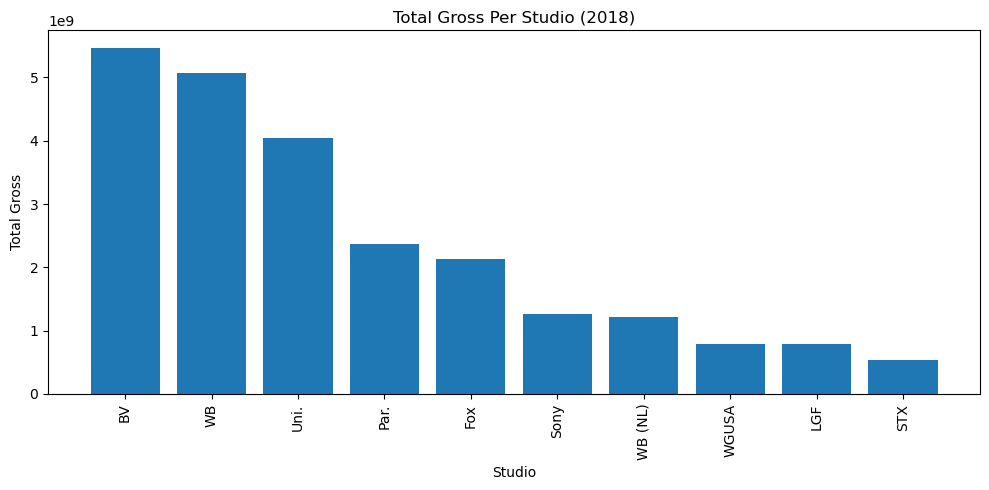

In [109]:
# Plot the top 10 grossing studios

fig, ax = plt.subplots(figsize=(10,5))

top_10_studios_2018 = list(gross_by_studio_2018.keys())[:10]
top_10_gross_2018 = list(gross_by_studio_2018.values)[:10]

ax.bar(top_10_studios_2018, top_10_gross_2018)

ax.set_title("Total Gross Per Studio (2018)")
ax.set_xlabel("Studio")
ax.set_ylabel("Total Gross")
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

In [110]:
# "Box office success" can be defined as reaching the revenue
# of the middle studio among the top 10 in 2018.

box_office_success_goal = top_10_gross_2018[4]

print(f"The middle-grossing studio among the top 10: {top_10_studios_2018[4]} with a total annual gross profit of ${box_office_success_goal:,}")

The middle-grossing studio among the top 10: Fox with a total annual gross profit of $2,128,500,000.0


The fifth-most-successful studio is Fox with a total annual gross profit of $2,128,500,000. We recommend that the new studio generates a minimum annual revenue of $2,128,500,000.

## 4.2 Conduct Statistical Test

- Use hypothesis testing (e.g., t-tests or ANOVA) to determine if certain variables (e.g., genre, budget) significantly impact movie success.

 ![totalgrossperstudio](../images/total%20gross%20per%20studio.png)

### Genres in the Box Office
Which genres should the new studio focus on in order to meet this minimum annual revenue?

We will use an ANOVA test to see whether some genres perform significantly better in the box office than others using 2018 data.

**Null Hypothesis:** All genres on average perform the same in the box office in 2018

**Alternative Hypothesis:** Genres on average perform significantly differently in the box office in 2018

In [111]:
# check to see if there are any null values in total_gross
data_2018["total_gross"].isnull().sum()

0

In [112]:
# Getting median total gross reveue for each individual genre
gross_by_genre_2018 = data_2018.groupby("individual_genre")["total_gross"].sum().sort_values(ascending=False)
gross_by_genre_2018

individual_genre
Adventure      1.606630e+10
Action         1.440009e+10
Comedy         9.288034e+09
Drama          6.961431e+09
Sci-Fi         6.558036e+09
Thriller       4.002375e+09
Animation      3.890969e+09
Fantasy        3.672559e+09
Horror         2.396202e+09
Biography      2.072138e+09
Family         1.973797e+09
Romance        1.899027e+09
Crime          1.751435e+09
Mystery        1.589606e+09
Music          9.370327e+08
Documentary    6.968814e+08
History        4.765831e+08
Musical        3.950000e+08
Sport          3.025210e+08
War            2.315100e+07
Western        2.400000e+06
Name: total_gross, dtype: float64

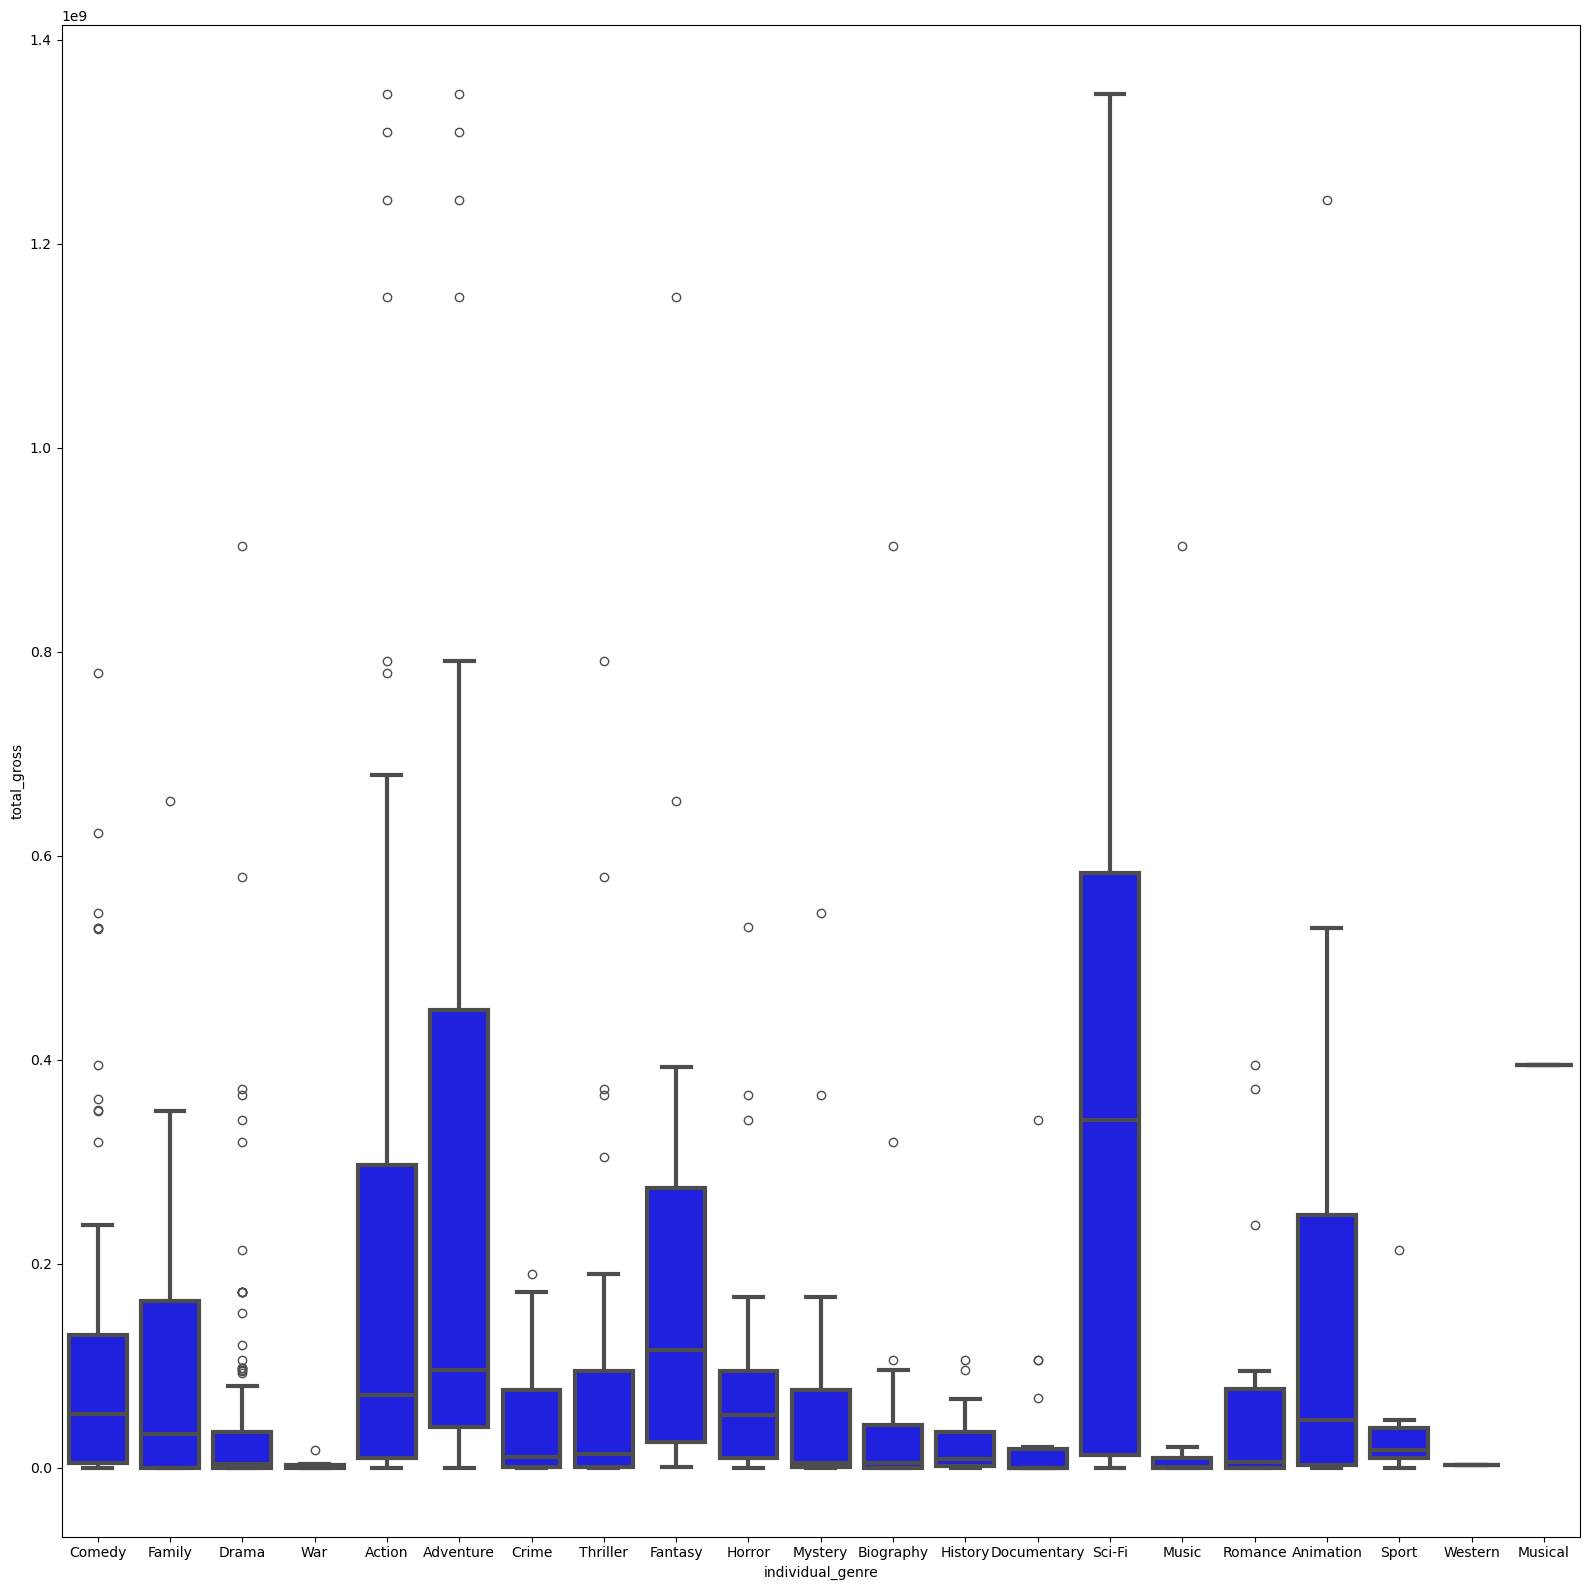

In [113]:
fig, ax = plt.subplots(figsize=(16, 16))

sns.boxplot(
    x="individual_genre",
    y="total_gross",
    data=data_2018,
    ax=ax,
    color="blue",
    linewidth=3
)

plt.tight_layout()

In [114]:
# define our alpha
alpha = 0.01

# get the list of genres in data
genres = list(data_2018["individual_genre"].unique())

# create dictionary of df for each genre
total_gross_data_per_genre_2018 = {}
for genre in genres:
    total_gross_data_per_genre_2018[genre] = list(data_2018[data_2018["individual_genre"] == genre]["total_gross"].values)

In [115]:
result = stats.f_oneway(*total_gross_data_per_genre_2018.values())
f_stat, p_value = result

p_value

4.0583942791545226e-18

In [116]:
p_value < alpha

True

Our p-value is less than our alpha, which means we can reject the null hypothesis. Genres on average perform significantly differently in the box office in 2018.

We know that there is a difference in box office success between genres, but we can look at the ANOVA table to know which genres are significantly different. 

In [117]:
# Look at the OLS ANOVA table
formula = "total_gross ~ C(individual_genre)"
anova_sm = ols(formula=formula, data=data_2018).fit()
anova_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_gross   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     7.039
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           4.06e-18
Time:                        16:35:53   Log-Likelihood:                -14836.
No. Observations:                 722   AIC:                         2.971e+04
Df Residuals:                     701   BIC:                         2.981e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           2.323e+08   2.62e+07      8.874      0.000    1.81e+08    2.84e+08
C(individual_genre)[T.Adventure]    4.475e+07   3.76e+07      1.189      0.235   -2.92e+07    1.19e+08
C(individual_genre)[T.Animation]   -3.771e+07    5.3e+07     -0.712      0.477   -1.42e+08    6.63e+07
C(individual_genre)[T.Biography]   -1.841e+08   4.09e+07     -4.501      0.000   -2.64e+08   -1.04e+08
C(individual_genre)[T.Comedy]      -1.162e+08   3.49e+07     -3.331      0.001   -1.85e+08   -4.77e+07
C(individual_genre)[T.Crime]       -1.925e+08   4.06e+07     -4.738      0.000   -2.72e+08   -1.13e+08
C(individual_genre)[T.Documentary] -1.974e+08    5.3e+07     -3.725      0.000   -3.01e+08   -9.34e+07
C(individual_genre)[T.Drama]       -1.911e+08   3.06e+07     -6.244      0.000   -2.51e+08   -1.31e+08
C(individual_genre)[T.Family]      -1.226e+08   5.52e+07     -2.222      0.027   -2.31e+08   -1.43e+07
C(individual_genre)[T.Fantasy]     -1.623e+07   5.64e+07     -0.288      0.774   -1.27e+08    9.45e+07
C(individual_genre)[T.History]     -2.072e+08    5.4e+07     -3.834      0.000   -3.13e+08   -1.01e+08
C(individual_genre)[T.Horror]      -1.435e+08   4.75e+07     -3.020      0.003   -2.37e+08   -5.02e+07
C(individual_genre)[T.Music]       -1.281e+08   7.35e+07     -1.743      0.082   -2.72e+08    1.62e+07
C(individual_genre)[T.Musical]      1.627e+08   2.08e+08      0.783      0.434   -2.45e+08    5.71e+08
C(individual_genre)[T.Mystery]      -1.66e+08   4.95e+07     -3.351      0.001   -2.63e+08   -6.88e+07
C(individual_genre)[T.Romance]      -1.78e+08   4.36e+07     -4.085      0.000   -2.64e+08   -9.25e+07
C(individual_genre)[T.Sci-Fi]       1.535e+08   5.64e+07      2.721      0.007    4.27e+07    2.64e+08
C(individual_genre)[T.Sport]       -1.818e+08   8.81e+07     -2.064      0.039   -3.55e+08   -8.85e+06
C(individual_genre)[T.Thriller]    -1.453e+08   4.01e+07     -3.622      0.000   -2.24e+08   -6.65e+07
C(individual_genre)[T.War]         -2.284e+08   8.81e+07     -2.592      0.010   -4.01e+08   -5.54e+07
C(individual_genre)[T.Western]     -2.299e+08   2.08e+08     -1.107      0.269   -6.38e+08    1.78e+08
==============================================================================
Omnibus:                      435.788   Durbin-Watson:                   0.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3728.479
Skew:                           2.664   Prob(JB):                         0.00
Kurtosis:                      12.775   Cond. No.                         28.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the table, we can see that coefficient for the `Adventure` genre had the largest positive effect on the total gross revenue. This means that Adventure movies earn $44,750,000 more than the baseline genre (intercept).

Alternatively, we can perform a Tukey's HSD Post-Hoc Test to find how genres and their median total gross revenue compare to one another.

In [118]:
tk_hsd = pairwise_tukeyhsd(data_2018["total_gross"], data_2018["individual_genre"], alpha=alpha)
tk_hsd.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

We can see from the Tukey's HSD Post-Hoc test that some genres perform significantly differently in the box office. For example, the adjusted p-value between Action vs Biography is `0.0015`, which is smaller than our alpha and suggests that their gross revenue is significantly different. However, Action vs Adventure have have a large adjusted p-value of `0.9999`, suggesting their box office performance is not significantly different.

In [119]:
# Find top performing genre
top_genre_2018 = list(gross_by_genre_2018.keys())[0]
top_genre_gross_2018 = list(gross_by_genre_2018.values)[0]

top_genre_2018, top_genre_gross_2018

('Adventure', 16066296500.0)

In [120]:
# Find all the genres that reach the total gross profit goal
top_genres_2018 = [genre for genre in gross_by_genre_2018.keys() if gross_by_genre_2018[genre] >= box_office_success_goal]
top_genres_2018

['Adventure',
 'Action',
 'Comedy',
 'Drama',
 'Sci-Fi',
 'Thriller',
 'Animation',
 'Fantasy',
 'Horror']

The top-performing genre of 2018 was Adventure with total gross profit of $16,066,296,500, surpassing our annual gross revenue of of $2,128,500,000. However, there are other genres that also surpass our goal: Action, Comedy, Drama, Sci-Fi, Thriller, Animation, Fantasy, and Horror.

![top performing generes.png](../images/top%20performing%20generes.png)

### Leverage Franchise Power
Prioritize the development or acquisition of film franchises, as movies that are part of a franchise (e.g., Avengers, Jurassic Park) tend to generate significantly higher revenue. The goal is to build long-term financial success through sequels and series.

Key Columns to focus on for this analysis:
- domestic_gross and foreign_gross for revenue.
- year for filtering data by 2018.
- genre for genre classification (for comparing genres within franchises).
- director for director consistency analysis.
- title for movie titles (identify franchises by titles).

Additional Considerations:
- Identify franchises by grouping related movies by title (e.g., "Avengers").
- Use total revenue to assess success.

In [121]:
# Filter the merged data for 2018
data_2018 = merged_data[merged_data['year'] == 2018]

In [122]:
# Calculate total revenue
data_2018['total_revenue'] = data_2018['domestic_gross'] + data_2018['foreign_gross']

/var/folders/8g/m6zcqnnd1p36dhf35mwkv0zw0000gn/T/ipykernel_44439/3458833843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2018['total_revenue'] = data_2018['domestic_gross'] + data_2018['foreign_gross']


In [123]:
# Create a function to identify franchise films based on keywords in the title
def check_franchise(title):
    franchise_keywords = ['Avengers', 'Star Wars', 'Harry Potter', 'Marvel', 'Toy Story', 
                          'Fast & Furious', 'Transformers', 'Pirates of the Caribbean', 'Spider-Man', 
                          'Batman', 'Superman', 'James Bond', 'X-Men', 'Jurassic', 'Mission: Impossible', 
                          'Despicable Me', 'Shrek', 'Hobbit', 'Lord of the Rings', 'Tomb Raider', 'Mamma Mia', ':',
                          'Detective Chinatown', 'Incredibles','Deadpool']
    for keyword in franchise_keywords:
        if keyword in title:
            return 'Yes'
    return 'No'

In [124]:
# Apply the function to create a new 'franchise' column
data_2018['franchise'] = data_2018['title'].apply(check_franchise)

/var/folders/8g/m6zcqnnd1p36dhf35mwkv0zw0000gn/T/ipykernel_44439/203577274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2018['franchise'] = data_2018['title'].apply(check_franchise)


In [125]:
# Group by title and franchise, and calculate total revenue
franchise_revenue = data_2018.groupby(['title', 'franchise'])['total_revenue'].sum().reset_index()

In [126]:
# Sort by highest total revenue, top 20 films
franchise_revenue = franchise_revenue.sort_values(by='total_revenue', ascending=False).head(20)

In [127]:
# Display top 20 franchise films by revenue
print(franchise_revenue)

                                           title franchise  total_revenue
17                        Avengers: Infinity War       Yes   4.072800e+09
29                                 Black Panther        No   4.041000e+09
92                Jurassic World: Fallen Kingdom       Yes   3.928500e+09
87                                 Incredibles 2       Yes   3.728400e+09
16                                       Aquaman        No   3.443400e+09
145                    Ralph Breaks the Internet        No   3.175200e+09
32                             Bohemian Rhapsody        No   2.710800e+09
122                Mission: Impossible - Fallout       Yes   2.373600e+09
46                                    Deadpool 2       Yes   2.337000e+09
197                                     The Mule        No   2.242500e+09
54   Fantastic Beasts: The Crimes of Grindelwald       Yes   1.961100e+09
14                          Ant-Man and the Wasp        No   1.867800e+09
146                             Ready 

- Movies that are part of a franchise (e.g., Deadpool, Avengers, Jurassic Park) generally outperform non-franchise films.
- Franchise films consistently bring in higher revenue, indicating the strong power of brand recognition and audience loyalty.

Developing franchises is a key strategy for maximizing long-term revenue. Studios should continue to invest in building and expanding franchises to capitalize on the momentum of successful series.

  ![franchisepower.png](../images/franchisepower.png)

### Director vs Studio Loyalty Analysis using a T-test

Hypothesis Testing:
- Null Hypothesis: There is no significant difference in total revenue between franchise movies directed by the same director and those directed by different directors.
- Alternative Hypothesis: Franchise movies directed by the same director generate higher revenue.

T-test will be used to compare the revenues of movies directed by the same director for a studio vs. those directed by different directors.

To group movies by director and analyze consistency within a studio:

In [128]:
# Filter data for 2018 and calculate total revenue
data_2018['total_revenue'] = data_2018['domestic_gross'] + data_2018['foreign_gross']

/var/folders/8g/m6zcqnnd1p36dhf35mwkv0zw0000gn/T/ipykernel_44439/2733569560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2018['total_revenue'] = data_2018['domestic_gross'] + data_2018['foreign_gross']


In [129]:
# Check director loyalty within a studio
director_loyalty = data_2018.groupby(['studio', 'director_name'])['total_revenue'].mean().reset_index()

In [130]:
# T-test: Compare revenue for movies directed by the same director vs. different directors
same_director = data_2018[data_2018.duplicated(subset=['studio', 'director_name'], keep=False)]
different_director = data_2018[~data_2018.duplicated(subset=['studio', 'director_name'], keep=False)]

In [131]:
# Perform T-test
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(same_director['total_revenue'], different_director['total_revenue'])

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 2.631564458646235, P-value: 0.008681228104616459


- A T-test comparing revenue from movies directed by loyal directors (e.g., Joe and Anthony Russo at BV) versus other directors produced a T-statistic of 2.63 and a P-value of 0.0086.
- Since the P-value < 0.05, we reject the null hypothesis, indicating that loyalty to specific directors has a statistically significant impact on a studio’s revenue. Studios that frequently collaborate with high-performing directors tend to see greater financial returns.

Studios should prioritize maintaining long-term relationships with successful directors. By fostering loyalty and consistency, studios can boost their chances of producing box-office hits.

  ![directorvsstudio](../images/directorvsstudio.png)

### Director vs Studio Loyalty Analysis attempt #2 using a linear regression

In [136]:
# Group by director and studio to get the median total gross
director_studio_median = data_2018.groupby(['director_id', 'studio'])['total_gross'].median().reset_index()

In [137]:
# Count the number of collaborations between each director and studio
director_studio_median['collaboration_count'] = data_2018.groupby(['director_id', 'studio'])['title'].count().values

In [138]:
# Perform linear regression using statsmodels
X = director_studio_median['collaboration_count']  # Independent variable: Collaboration count
y = director_studio_median['total_gross']  # Dependent variable: Median total gross
X = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     16.46
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           6.35e-05
Time:                        16:36:50   Log-Likelihood:                -6117.1
No. Observations:                 298   AIC:                         1.224e+04
Df Residuals:                     296   BIC:                         1.225e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.831e+07    

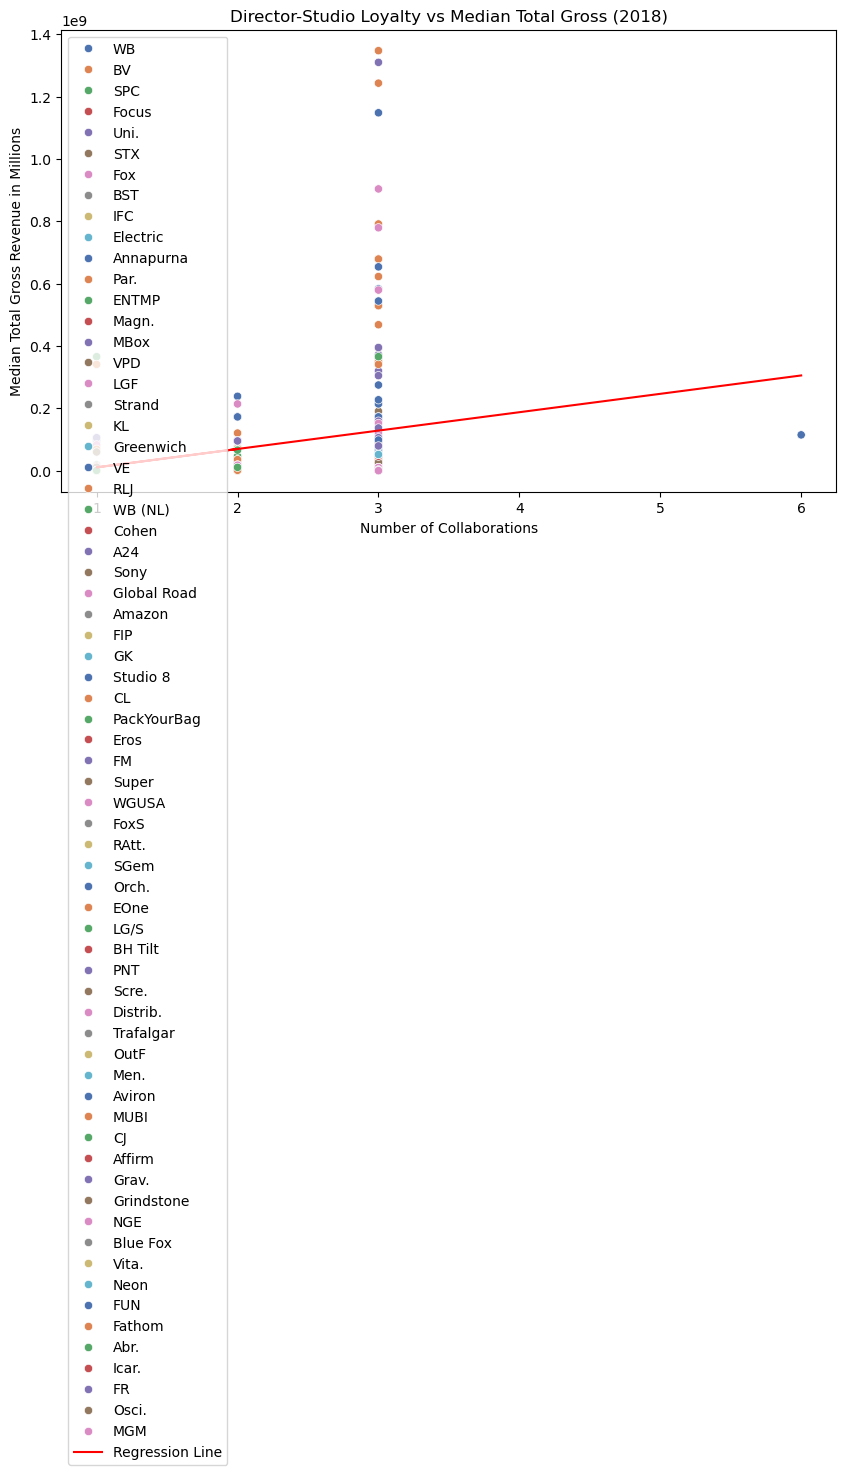

In [139]:
# Plot the data using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=director_studio_median, x='collaboration_count', y='total_gross', hue='studio', palette='deep')
plt.plot(director_studio_median['collaboration_count'], model.predict(X), color='red', label='Regression Line')

plt.title('Director-Studio Loyalty vs Median Total Gross (2018)')
plt.xlabel('Number of Collaborations')
plt.ylabel('Median Total Gross Revenue in Millions')
plt.legend(loc='upper left')
plt.show()

Regression Coefficient (collaboration count):
- Coefficient: 5.895e+07 (roughly 58.95 million)
- This means that for each additional collaboration between a director and a specific studio, the total gross revenue increases by approximately $58.95 million.
- Impact: Director-studio loyalty positively influences box office success. As directors work more frequently with the same studio, their movies tend to generate significantly higher total gross revenue.

Intercept: -4.831e+07 (roughly -48.31 million)
- The negative intercept suggests that with zero collaborations, the baseline total gross revenue would be negative (which isn't realistic for box office revenue). However, it emphasizes that increasing the number of collaborations brings about significant positive changes in total gross.

R-squared: 0.053
- This indicates that only 5.3% of the variance in total gross revenue can be explained by the number of collaborations between directors and studios.
- Impact: While director-studio loyalty does have a statistically significant impact, other factors (like genre, marketing, and cast) also play substantial roles in box office performance.

### Analysis & Results ##

Genres in the Box Office

Using 2018 data, we performed an ANOVA test to determine whether there are significant differences in box office performance across genres. The results indicate that genres do not perform equally. The Null Hypothesis that all genres on average perform the same in the box office in 2018 was rejected (p-value < 0.05).

We used Tukey’s HSD Post-Hoc Test to identify specific genre pairs that have significantly different box office performance. The test shows that Adventure movies are the top performers, with an additional $44,750,000 in total gross revenue compared to the baseline genre. Action, Comedy, Sci-Fi, Drama, and Animation also perform well, surpassing the new studio’s target revenue of $2,128,500,000.

Franchise Power

Franchise movies were analyzed using a binary feature that identified whether a movie belonged to a franchise. The data showed that franchise films significantly outperformed non-franchise films in 2018. Major franchises like Avengers, Jurassic Park, and Deadpool generated higher revenues due to brand loyalty and anticipation for sequels.

For example:

- Avengers: Infinity War, an action-adventure franchise movie, generated over $16 billion in 2018, far surpassing non-franchise films.
- Ralph Breaks the Internet, another franchise film, brought in half the revenue of Avengers but still performed significantly better than non-franchise films in its genre.

Director vs Studio Loyalty

A t-test was conducted to compare the total revenue between directors who consistently work with the same studio and those who do not. The results were statistically significant (T-statistic: 2.63, P-value: 0.0086), indicating that directors with established studio partnerships tend to produce higher-grossing films. For instance, movies directed by the Russo Brothers consistently generate billions in revenue, particularly when working with studios like BV or Fox.

Top-grossing studios in 2018 included BV, Fox, Universal, and Warner Bros, with films like Avengers: Infinity War directed by the Russo Brothers pulling in over $45 billion.

When analyzing the linear regression indicates that director-studio loyalty has a positive impact on total gross revenue, with each additional collaboration between a director and a studio resulting in an average increase of approximately **$58.95 million** in box office earnings. Although director-studio loyalty is statistically significant (p-value < 0.001), it explains only **5.3%** of the variation in total gross revenue, suggesting that other factors also contribute to a movie's box office success.


### Recommendations
- The new studio should prioritize producing Adventure and Action films, as these genres consistently generate the highest revenue. Other high-performing genres include Comedy, Sci-Fi, Fantasy, and Animation, which also exceed the annual revenue target.
- The studio should prioritize building franchise films, especially in high-performing genres. Franchise films create brand loyalty and generate long-term revenue streams.
- The studio should invest in long-term partnerships with proven directors. Directors who have a history of success with a studio are more likely to bring in higher box office revenue, especially when aligned with franchises or popular genres.

### Conclusion

1. Adventure and Action genres should be the studio’s focus, as they consistently generate the highest box office revenue, exceeding the target annual revenue of $2,128,500,000.
2. Franchise development is key to long-term financial success. Studios should prioritize creating or investing in franchises that attract loyal audiences and provide opportunities for sequels.
3. Director-studio loyalty leads to better financial outcomes. New studios should focus on building strong, long-term relationships with successful directors who specialize in high-grossing genres and franchises.

### Additional Insights 
- Invest in High-Revenue Genres: Genres like Adventure, Action, and Sci-Fi outperform others and should be the core focus for new releases.
- Develop Franchise Films: Building a long-term franchise strategy will ensure consistent revenue, as franchise films outperform standalone movies.
- Foster Talent Relationships: Collaborating with proven directors will not only improve movie performance but also contribute to the studio’s brand and audience retention.

### Overall Strategic Enchancements 
- Focus on producing Adventure and Action films, leveraging their box office dominance.
- Build franchises and cultivate brand loyalty to drive long-term financial success.
- Align with proven directors who have a track record of box office success to maximize profitability.



### Next Steps

- Genre-Based Investments: Allocate resources to high-performing genres, particularly Adventure, Action, and Animation.
- Franchise Feasibility Study: Evaluate potential franchise opportunities for sequels or spin-offs.
- Talent Acquisition Strategy: Develop contracts with directors who have a history of success in target genres, ensuring continuity and creative control for future films.